In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data_df=pd.read_csv('heart-numerical.csv')

In [2]:
data_df.describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604,0.663366
std,9.038662,17.599748,51.776918,22.875003,1.161075,0.934375
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000


In [3]:
from sklearn.model_selection import train_test_split

# Create X/y arrays
X = data_df.drop('disease', axis=1).values
y = data_df.disease.values

# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', KNeighborsClassifier(n_neighbors=5))
])

# Fit estimator
knn_pipe.fit(X_tr, y_tr)

# Evaluate on test set
accuracy = knn_pipe.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy)) # 0.747

Accuracy: 0.747


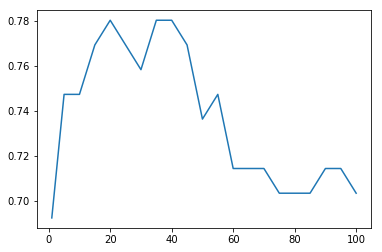

In [26]:
# Tunig K with grid search
k_values=np.r_[1, np.arange(5, 101, step=5)]
accuracy_result=[]
for k in k_values:
    knn_pipe.set_params(estimator__n_neighbors=k)
    knn_pipe.fit(X_tr, y_tr)
    accuracy_result.append(knn_pipe.score(X_te, y_te))

plt.plot(k_values, accuracy_result)

In [23]:
# [Code adapted from the previous course]
# Variable to store the results
gs_results = []

# Grid search
for k in k_values:
    # Fit k-NN model
    knn_pipe.set_params(estimator__n_neighbors=k)
    knn_pipe.fit(X_tr, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append({
        'k': k,
        'train_accuracy': knn_pipe.score(X_tr, y_tr),
        'test_accuracy': knn_pipe.score(X_te, y_te)
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by='test_accuracy', ascending=False).head()

,k,test_accuracy,train_accuracy
8,40,0.780220,0.740566
4,20,0.780220,0.754717
7,35,0.780220,0.768868
3,15,0.769231,0.768868
5,25,0.769231,0.768868


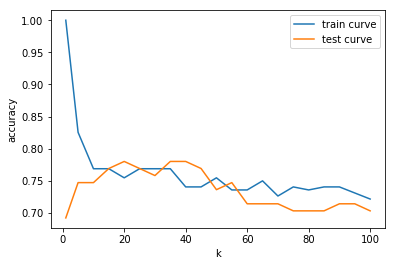

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.plot(gs_results['k'], gs_results['train_accuracy'], label='train curve')
plt.plot(gs_results['k'], gs_results['test_accuracy'], label='test curve')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

In [39]:
# Run several times the evaluation
gs_results = []
for run_idx in range(30):
    # Split into train/test sets
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.3, random_state=run_idx)

    # Grid search
    for k in k_values:
        # Fit k-NN model
        knn_pipe.set_params(estimator__n_neighbors=k)
        knn_pipe.fit(X_tr, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append({
            'k': k,
            'run_idx': run_idx,
            'train_accuracy': knn_pipe.score(X_tr, y_tr),
            'test_accuracy': knn_pipe.score(X_te, y_te)
        })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.groupby('k').mean().sort_values('test_accuracy', ascending=False).head(3)

,run_idx,test_accuracy,train_accuracy
k,,,
35,14.5,0.760440,0.767296
30,14.5,0.758974,0.766352
45,14.5,0.758242,0.764465


In [40]:
# Group results by alpha value
grouped = gs_results.groupby('k')

# Compute train/test mean scores with std
mean_tr = grouped.train_accuracy.mean()
mean_te = grouped.test_accuracy.mean()
std_tr = grouped.train_accuracy.std()
std_te = grouped.test_accuracy.std()

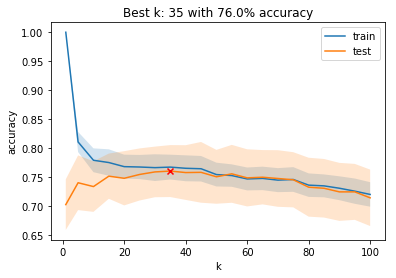

In [41]:
# Plot mean scores
plt.plot(k_values, mean_tr, label='train')
plt.plot(k_values, mean_te, label='test')

# Add marker for best score
best_k = mean_te.idxmax()
plt.scatter(best_k, mean_te.max(), marker='x', c='red', zorder=10)

# Quantify variance with ±std curves
plt.fill_between(k_values, mean_tr-std_tr, mean_tr+std_tr, alpha=0.2)
plt.fill_between(k_values, mean_te-std_te, mean_te+std_te, alpha=0.2)
plt.title('Best k: {} with {:.1f}% accuracy'.format(best_k, 100*mean_te[best_k]))
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import classification_report

# Tuned k-NN estimator
tuned_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])
tuned_knn.fit(X_tr, y_tr)

# Classification report
y_te_preds = tuned_knn.predict(X_te)
print(classification_report(y_true=y_te, y_pred=y_te_preds))

              precision    recall  f1-score   support

     absence       0.59      0.90      0.71        41
    presence       0.86      0.48      0.62        50

   micro avg       0.67      0.67      0.67        91
   macro avg       0.72      0.69      0.66        91
weighted avg       0.74      0.67      0.66        91



In [43]:
# Compute probabilities
y_te_probs = tuned_knn.predict_proba(X_te)
print('Predictions:', y_te_preds[:5]) # ['absence' 'presence' 'presence' 'absence' 'presence']
print('Probs:')
print(y_te_probs[:5])

Predictions: ['absence' 'presence' 'presence' 'absence' 'presence']
Probs:
[[0.8        0.2       ]
 [0.14285714 0.85714286]
 [0.25714286 0.74285714]
 [0.74285714 0.25714286]
 [0.22857143 0.77142857]]


In [46]:
from sklearn.metrics import roc_curve

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_te, y_score=y_te_probs[:, 1], pos_label='presence')

In [47]:
pd.DataFrame({
    'fpr': fpr,
    'tpr (recall)': tpr,
    'thresholds': thresholds
}).head(5)

,fpr,tpr (recall),thresholds
0,0.00000,0.00,1.942857
1,0.00000,0.02,0.942857
2,0.00000,0.06,0.885714
3,0.02439,0.12,0.857143
4,0.02439,0.18,0.828571


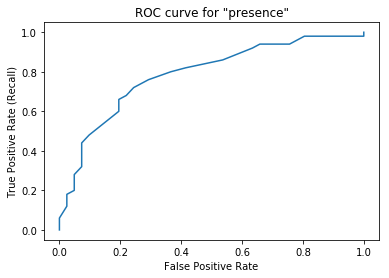

In [48]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC curve for "presence"')
plt.show()